In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
PATH = '/content/drive/MyDrive/Parallel_PDE_project/fourier_neural_operator'
os.chdir(PATH)

In [4]:
#Parameters
ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

r = 5
h = int(((421 - 1)/r) + 1)
s = h

In [5]:
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Parallel_PDE_project/fourier_neural_operator/Notebooks')

In [6]:
from utils import * 
from Adam import * 

In [7]:
################################################################
# load data and data normalization
################################################################
Darcy_flow_dir =  os.path.join(PATH, 'data', 'DarcyFlow')
x_train = torch.load( os.path.join(Darcy_flow_dir, 'darcy_flow_x_train.pt'))
y_train = torch.load(os.path.join(Darcy_flow_dir, 'darcy_flow_y_train.pt'))
x_test = torch.load(os.path.join(Darcy_flow_dir, 'darcy_flow_x_test.pt'))
y_test= torch.load(os.path.join(Darcy_flow_dir, 'darcy_flow_y_test.pt'))

([], <a list of 0 Text major ticklabel objects>)

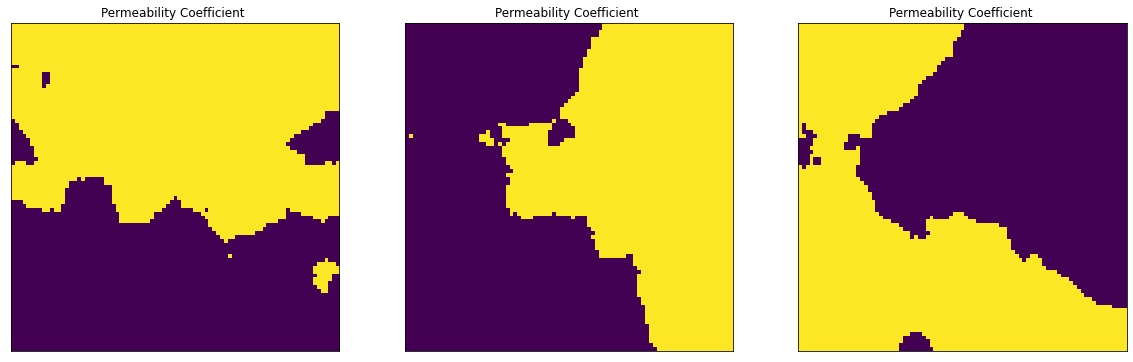

In [8]:
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(x_train[1,...])
plt.title('Permeability Coefficient ')
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(x_train[10,...])
plt.title('Permeability Coefficient ')
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(x_train[100,...])
plt.title('Permeability Coefficient ')
plt.xticks([])
plt.yticks([])

In [9]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,s,s,1)
x_test = x_test.reshape(ntest,s,s,1)

In [10]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [11]:
model = FNO2d(modes, modes, width).to(device)

NameError: ignored

In [ ]:
model

FNO2d(
  (fc0): Linear(in_features=3, out_features=32, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (w0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
loss_train = []
loss_test =  []
epoch_vec = []

In [ ]:
filename = f'FNO2D_epoch_{epochs}_wave_number_{modes}_features_{width}'
filename

'FNO2D_epoch_500_wave_number_12_features_32'

In [ ]:
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=epochs)
myloss = LpLoss(size_average=False)
y_normalizer.to(device)

################################################################
# training and evaluation
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, s)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()
    
    epoch_vec.append(ep)
    #e= epoch_vec[-1]
    #epoch_vec.append(e+1)
    
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest

    loss_train.append(train_l2)
    loss_test.append(test_l2)

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2)
  

1188353
0 2.742598006000094 0.2475257043838501 0.2510776853561401
1 2.2933168660000547 0.24519155979156493 0.24795473575592042
2 2.2818506340000795 0.24030137729644777 0.2407270860671997
3 2.2787220720000505 0.22912892818450928 0.2243803310394287
4 2.2743460320000395 0.20522134685516358 0.19150431632995604
5 2.276376007000067 0.16242299127578735 0.13956788539886475
6 2.344548581999902 0.12124585330486298 0.11704154253005981
7 2.3740742759999875 0.11257684445381165 0.11419730424880982
8 2.371630239000069 0.11070213758945466 0.1131499481201172
9 2.354049873000008 0.1095308187007904 0.11198662042617798
10 2.3572199140000976 0.10850145637989045 0.11109847068786621
11 2.36432952999985 0.10761939442157745 0.110147705078125
12 2.357676050000009 0.10666525077819825 0.10951510667800904
13 2.3721412729998974 0.10574968981742859 0.1087652325630188
14 2.3626916400000937 0.10463047683238984 0.10742638111114503
15 2.3716409670000758 0.10350936806201935 0.10646886467933654
16 2.36569068599988 0.10236

In [ ]:
print(f'saving model at epoch {ep}')
file_path = os.path.join(PATH, 'trained_models')
torch.save(model, os.path.join(file_path, filename+'.plt'))

saving model at epoch 499


Text(0.5, 1.0, 'Test loss')

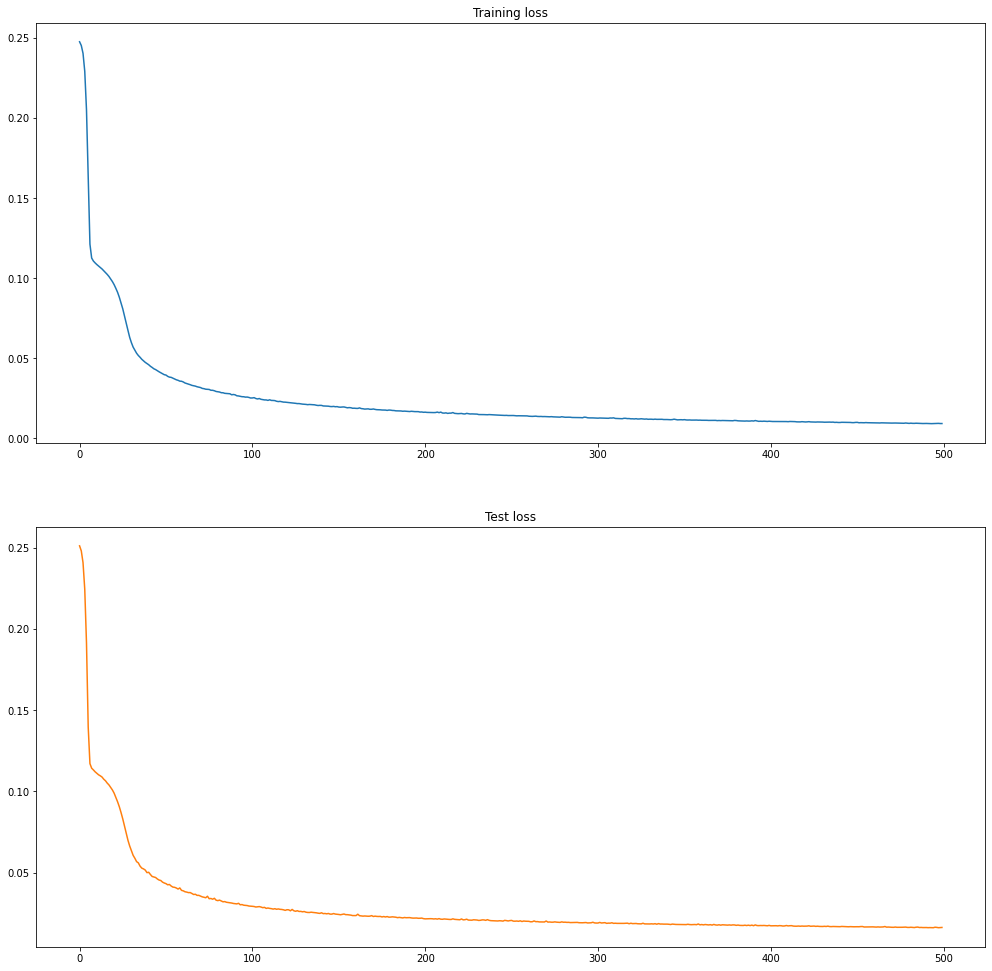

In [ ]:
  fig, axs = plt.subplots(2, 1, figsize=(17,17))
  axs[0].plot(epoch_vec, loss_train)
  axs[0].set_title(f'Training loss')
  axs[1].plot(epoch_vec, loss_test, 'tab:orange')
  axs[1].set_title('Test loss')
  plt.savefig(os.path.join(PATH, 'figures', filename+'.png'))

<Figure size 432x288 with 0 Axes>